# This notebook is to predict the ProteinMPNN optimised sequences using AF2 and partial masked templates
*This Notebook runs ColabDesign version of AF2*

## 1.0 Libraries

In [ ]:
import jax, os, copy, pickle, glob, datetime, shutil
import jax.numpy as jnp
import numpy as np

from colabdesign import mk_af_model

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm

from colabdesign.af.alphafold.common import protein
from colabdesign.shared.protein import renum_pdb_str
from colabdesign.af.alphafold.common import residue_constants

from colabdesign.af.loss import *
from colabdesign.af.loss import _get_pw_loss

from Bio.PDB import PDBParser
from Bio import SeqUtils
from scipy.spatial.distance import cdist

## 2.0 Functions

In [ ]:
def rank_array_predict(input_array):
    # numpy.argsort returns the indices that would sort an array.
    # We convert it to a python list before returning
    return list(np.argsort(input_array))[::-1]

def rank_and_write_pdb_predict(af_model, name, write_all=False, renum_pdb = True):
    ranking = rank_array_predict(np.mean(af_model.aux['all']['plddt'],-1))
    if write_all != True:
        ranking = [ranking[0]]
    
    aux = af_model.aux
    aux = aux["all"]
    
    p = {k:aux[k] for k in ["aatype","residue_index","atom_positions","atom_mask"]}
    p["b_factors"] = 100 * p["atom_mask"] * aux["plddt"][...,None]
    
    def to_pdb_str(x, n=None):
        p_str = protein.to_pdb(protein.Protein(**x))
        p_str = "\n".join(p_str.splitlines()[1:-2])
        if renum_pdb: p_str = renum_pdb_str(p_str, af_model._lengths)
        #if n is not None:
        #    p_str = f"MODEL{n:8}\n{p_str}\nENDMDL\n"
        return p_str

In [8]:
def get_interface_info(pdb:str, binder_chain:str, thresh:float=5.0) -> str:
    """
    This function is to return the string of hotpots for a certain structure
    :params:
        - pdb          : the pdb to be processed
        - binder_chain : the binder chain ID for which the hotspot residues will be defined
        - thresh       : Distance threshold below which a residue would be considered as a hotspot, DEFAULT = 5.0 A 
    """
      
    # load the pdb file
    struct = PDBParser(QUIET=True).get_structure(os.path.basename(pdb), pdb)
    
    # define the chains
    binder_chains = list(binder_chain)
    target_chains = [x.id for x in struct.get_chains() if x.id not in binder_chains]

    # get binder and target lengths
    binder_chain_length = len(struct[0][binder_chains[0]])
    target_chain_length = len(struct[0][target_chains[0]])
    
    # get binder first resnum
    binder_first_res_num = int(list(struct[0][binder_chains[0]].get_residues())[0].id[1])
    target_first_res_num = int(list(struct[0][target_chains[0]].get_residues())[0].id[1])
    target_last_res_num = int(list(struct[0][target_chains[0]].get_residues())[-1].id[1])

    # get the atom coords 
    target_atoms = np.array([atom.get_coord() for atom in struct.get_atoms() if atom.get_full_id()[2] in target_chains if 'H' not in atom.get_full_id()[4][0]])
    binder_atoms = np.array([atom.get_coord() for atom in struct.get_atoms() if atom.get_full_id()[2] in binder_chains if 'H' not in atom.get_full_id()[4][0]])
    
    # map atoms to residues
    binder_residues = np.array([atom.get_parent().id[1] for atom in struct.get_atoms() if atom.get_full_id()[2] in binder_chains if 'H' not in atom.get_full_id()[4][0]])
    
    # generate the distance matrix
    dists = cdist(target_atoms, binder_atoms)
    
    # return the binder atoms that are closest to target chains
    closest_binder_atoms_clac = np.argmin(dists, axis=1)
     
    # get binder atoms that are within the targeted threshold
    closest_binder_atoms = closest_binder_atoms_clac[dists[np.arange(len(dists)), closest_binder_atoms_clac] < thresh]
    
    # get the hotspot residues that correspond to the closest atoms
    hotspot_residues = sorted(list(set(binder_residues[closest_binder_atoms])))
    
    # generate the hotspots list
    hotspots = [int(item) for item in hotspot_residues]
    
    return hotspots, binder_first_res_num, binder_chain_length, binder_chains[0], target_chains[0], target_first_res_num, target_last_res_num

In [9]:
def extract_target_info(path:str, target_chain:str):
    """ This function is to extract the target protein """
    # load target
    parser1 = PDBParser(QUIET=True)
    struct = parser1.get_structure(os.path.basename(path), path)[0][target_chain]   
    target_seq = SeqUtils.seq1("".join([r.get_resname() for r in struct.get_residues()]))
    return target_seq

In [10]:
def plot_af_scores(df:pd.DataFrame, outpath:str, iden:str, export:bool=False, show:bool=False):
    """
    """
    
    labels = {
        'plddt':'pLDDT',
        'ptm' : 'pTM',
        'iptm': 'Interface pTM', 
        'rmsd':'RMSD (A)' 
               }
    
    fig, axs = plt.subplots( nrows=1, ncols=len(list(labels.keys())), figsize=[15,6] )

    for i,k in enumerate(labels.keys()):
        sns.violinplot(y=k,  data=df, ax=axs[i], inner='points', color='#DCDCDC')
        axs[i].set_ylabel(labels[k], fontsize=12 ,labelpad= 10.0)

    plt.suptitle(f"""{df.shape[0]} {iden}
    """, fontsize=16, fontweight='bold')
    plt.tight_layout(h_pad=5.0, w_pad=3.0)

    if export:
        plt.savefig(f'{outpath}/{datetime.date.today()}_{iden.lower().replace(" ", "_")}.png', format="png" ,dpi=300, transparent=True)
        plt.savefig(f'{outpath}/{datetime.date.today()}_{iden.lower().replace(" ", "_")}.svg', format="svg" ,dpi=300, transparent=False)
    
    if show:
        plt.show()
    else:
        plt.close()
    
    return None

## 3.0 I/O

In [ ]:
# make main output folder
output = './opt_designs/af_mulltimer_pred/'
os.makedirs(output, exist_ok=0)

# make af pred output folder
af_pred = os.path.join(output, 'af_pred')
os.makedirs(af_pred, exist_ok=0)

# make pdb output folder
pdb_out = os.path.join(af_pred, 'pdbs')
os.makedirs(pdb_out, exist_ok=0)

# make score output folder
sc_out = os.path.join(af_pred, 'scores')
os.makedirs(sc_out, exist_ok=0)

# make af pred analysis output folder
af_pred_anal = os.path.join(output, 'af_pred_analysis')
os.makedirs(af_pred_anal, exist_ok=0)

# make best pdbs out
best_pdb_out = os.path.join(af_pred_anal, 'best_pdbs')
os.makedirs(best_pdb_out, exist_ok=0)

In [ ]:
target_models = "{PATH_TO_Rs_MODELS}"
binder_chain_input = 'B'
interface_thresh = 5.0

## 4.0 Execution

In [13]:
# path to input structures
target_models_paths = [p.strip() for p in glob.iglob(os.path.join(target_models, '*.pdb'))]
print(str(len(target_models_paths)) + ' Parsed input files')
print(target_models_paths[0])

1998 Parsed input files
./designs_w_fixed_target_af_template/ems_thioM_830_S69.pdb


In [ ]:
# parse af monomer selection results
df_parsed = pd.read_csv("{PATH_TO_AF2_monomer_SELECTION_RESULTS}", index_col=0)
print(str(df_parsed.shape[0]) + ' Parsed sequences')

3123 Parsed sequences


In [16]:
# map the mpnn to the source models
map_dic = {}

for gp01 in df_parsed.groupby(by='parent'):
    path_ = [os.path.abspath(p) for p in target_models_paths if gp01[0].replace('x','_') in p][0]
    mpnn_seqs = [(d.replace('>',''),s) for d,s in zip(gp01[1].label, gp01[1].sequence)]
    assert gp01[1].shape[0] == len(mpnn_seqs), 'Parsing error'
    map_dic[path_] = mpnn_seqs

In [ ]:
# re-predict
print('Predicting...')
for pdb, mpnned in tqdm(map_dic.items()):
    # get target information
    design_pos, binder_first_res_num, binder_chain_length, binder_chain, target_chain, target_first_res_num, target_last_res_num = get_interface_info(pdb=pdb, binder_chain=binder_chain_input, thresh=interface_thresh)
    
    # the positions we want to keep fixed to AF2seq
    fix_pos = []
    for i in range(int(binder_first_res_num), binder_chain_length + 1):
        if i not in design_pos:
            fix_pos.append(f"{binder_chain}" + str(i))
    for i in range(target_first_res_num, target_last_res_num + 1):
        fix_pos.append(f"{target_chain}" + str(i))
    # get the fixed positions
    fix_pos = ','.join(fix_pos)
    
    # initialise af
    af_model = mk_af_model(protocol='fixbb', use_templates=True, initial_guess=False,data_dir='{PATH_TO_params_FOLDER}/params/')
    af_model.prep_inputs(pdb_filename=pdb, chain=f'{target_chain},{binder_chain}', fix_pos=fix_pos)
    
    # Mask design positions from template
    for j in design_pos:
        af_model._inputs['batch']['all_atom_mask'][j-1,:] = np.zeros_like(af_model._inputs['batch']['all_atom_mask'][j-1,:])
    
    for item in mpnned:
        name_ = item[0]
        seq_ = item[1]
        # get the complex sequence from the pdb Target + Design
        cmplx_seq = extract_target_info(path=pdb, target_chain=target_chain) + seq_ 
        # run the prediction
        af_model.set_seq(cmplx_seq)
        af_model.predict(num_recycles=3, models = [0,1], num_models=2)
        pdbs = rank_and_write_pdb_predict(af_model, name=os.path.join(pdb_out,name_))
        
        # get af scores
        af_sc = pd.DataFrame({'design':name_,
                              'plddt':af_model.aux['all']['plddt'].mean(),
                              'ptm':af_model.aux['all']['ptm'].mean(),
                              'iptm':af_model.aux['all']['i_ptm'].mean(),
                              'rmsd':af_model.aux['all']['losses']['rmsd'].mean()}, index=[0])
        af_sc.to_csv(os.path.join(sc_out, name_+'_scores.csv'))

Predicting...


  0%|          | 0/1132 [00:00<?, ?it/s]

predict models [0, 1] recycles 3 hard 1 soft 0 temp 1 seqid 0.84 loss 1.01 dgram_cce 1.01 plddt 0.87 ptm 0.70 i_ptm 0.25 rmsd 2.93
predict models [0, 1] recycles 3 hard 1 soft 0 temp 1 seqid 0.84 loss 1.02 dgram_cce 1.02 plddt 0.88 ptm 0.67 i_ptm 0.16 rmsd 2.71
predict models [0, 1] recycles 3 hard 1 soft 0 temp 1 seqid 0.81 loss 0.98 dgram_cce 0.98 plddt 0.88 ptm 0.70 i_ptm 0.25 rmsd 2.98
predict models [0, 1] recycles 3 hard 1 soft 0 temp 1 seqid 0.81 loss 0.84 dgram_cce 0.84 plddt 0.89 ptm 0.82 i_ptm 0.61 rmsd 1.25
predict models [0, 1] recycles 3 hard 1 soft 0 temp 1 seqid 0.84 loss 0.98 dgram_cce 0.98 plddt 0.88 ptm 0.72 i_ptm 0.28 rmsd 2.14
predict models [0, 1] recycles 3 hard 1 soft 0 temp 1 seqid 0.87 loss 1.11 dgram_cce 1.11 plddt 0.88 ptm 0.67 i_ptm 0.11 rmsd 3.57
predict models [0, 1] recycles 3 hard 1 soft 0 temp 1 seqid 0.85 loss 1.12 dgram_cce 1.12 plddt 0.88 ptm 0.67 i_ptm 0.09 rmsd 5.65
predict models [0, 1] recycles 3 hard 1 soft 0 temp 1 seqid 0.86 loss 1.05 dgram_cc

In [18]:
# Parse af model scores
sc_paths = [p.strip() for p in glob.iglob(os.path.join(sc_out, '*.csv'))]
df_af_sc = pd.concat([pd.read_csv(s, index_col=0) for s in sc_paths])
df_af_sc.sort_values(by='iptm', ascending=False, inplace=True)
df_af_sc.reset_index(drop=True, inplace=True)
df_af_sc.to_csv(os.path.join(af_pred_anal, 'all_af_models_scores.csv'))
print(str(df_af_sc.shape[0]) + ' Parsed Designs')

12847 Parsed Designs


In [19]:
# get best designs based on the iptm scores
df_af_sel = df_af_sc.copy()[(df_af_sc.iptm >= 0.7)].reset_index(drop=True)
df_af_sel.to_csv(os.path.join(af_pred_anal, 'best_af_models_scores.csv'))
print(str(df_af_sel.shape[0]) + ' Best designs')

545 Best designs


In [20]:
# get the best designs
pdb_paths = [p.strip() for p in glob.iglob(os.path.join(pdb_out,'*.pdb'))]

for des in tqdm(df_af_sel.design, desc='Copying best designs'):
    path_ = [p for p in pdb_paths if des in p][0]
    shutil.copy(path_, os.path.join(best_pdb_out, os.path.basename(path_)))

Copying best designs:   0%|          | 0/545 [00:00<?, ?it/s]

Ploting...


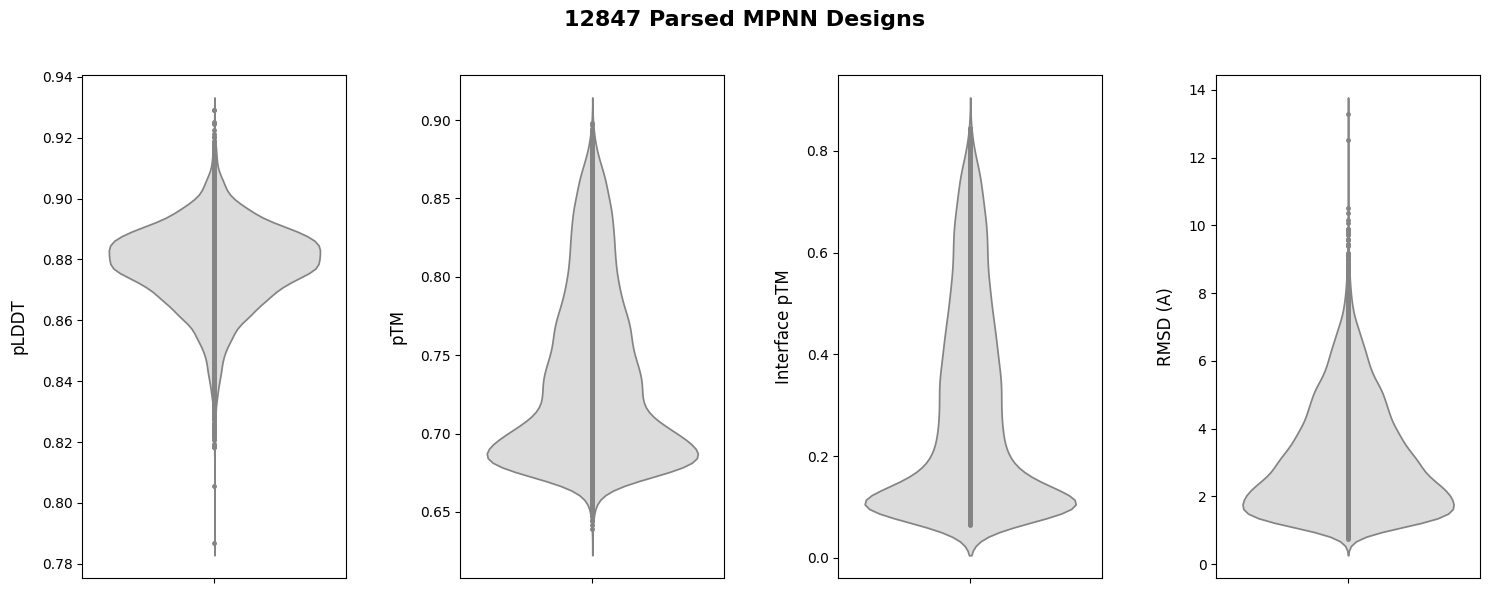

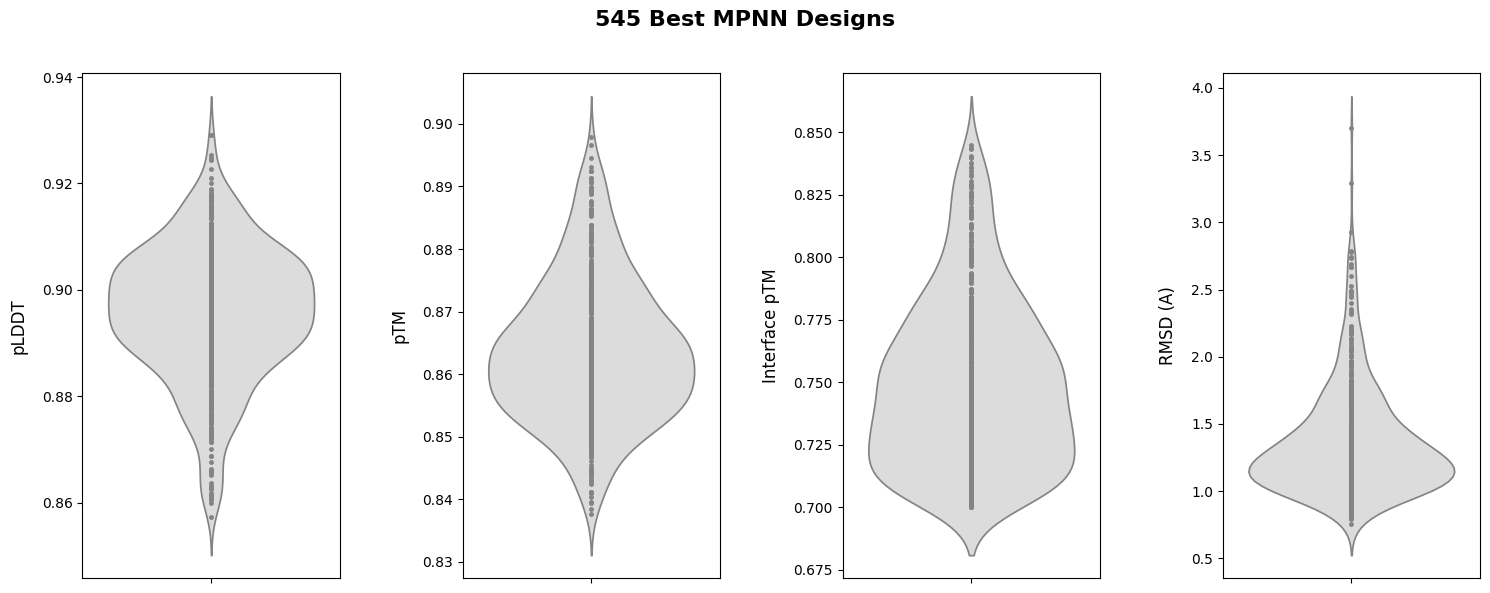

In [21]:
# plot scores
print('Ploting...')
plot_af_scores(df=df_af_sc, iden='Parsed MPNN Designs', outpath=af_pred_anal, export=True, show=True)
plot_af_scores(df=df_af_sel, iden='Best MPNN Designs', outpath=af_pred_anal, export=True, show=True)